Text(0.5, 1.0, 'k-mer with k = 3 in down_genes')

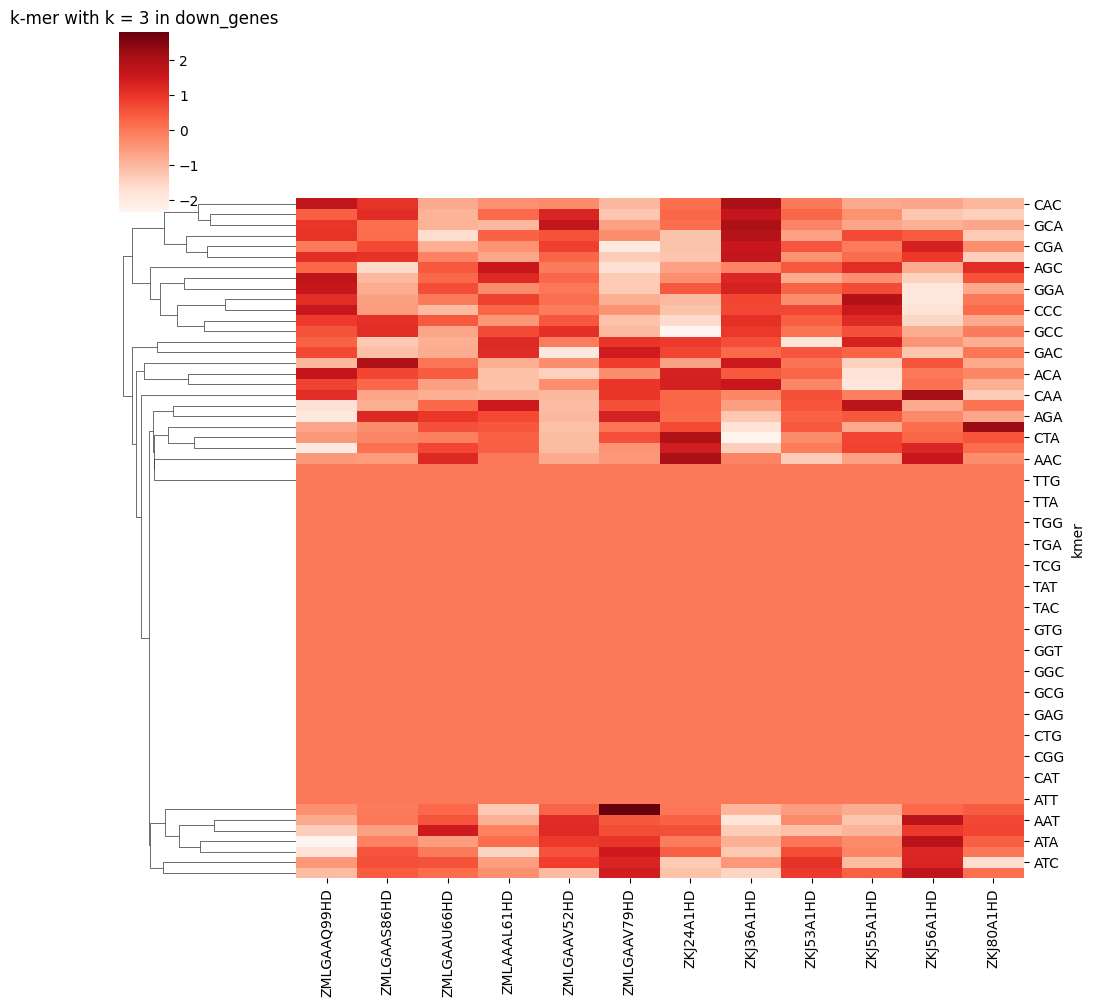

In [ ]:
import pandas as pd
import numpy as np 
import pathlib 
from tqdm import tqdm
import seaborn as sns
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt

# enrichment_type = "up_genes"
enrichment_type = "down_genes"
# enrichment_type = "all_genes"
inputdir = f"/Volumes/HNSD01/outdir/highdepth_WGS_TSS_customGenes/kmc3_dump_count/Lung/biomart/{enrichment_type}"
kmer_size = 3

all_files = [item for item in pathlib.Path(inputdir).glob(f"*_{kmer_size}.txt")]

if kmer_size == 2:
    all_kmers = [f"{i}{j}" for i in "ACGT" for j in "ACGT"]
elif kmer_size == 3:
    all_kmers = [f"{i}{j}{k}" for i in "ACGT" for j in "ACGT" for k in "ACGT"]

df = pd.DataFrame(data = all_kmers, columns = ["kmer"])

metadata = pd.read_csv("metadata.csv")
cancer_samples = metadata[metadata["Label"] == "Cancer"]["LABCODE"].tolist()
control_samples = metadata[metadata["Label"] == "Control"]["LABCODE"].tolist()
for file in all_files:
    tmpdf = pd.read_csv(file, sep = "\t", header = None, names = ["kmer", "count"])
    sample = file.name.split("_")[0].split("-")[1]
    tmpdf["count"] = tmpdf["count"] / tmpdf["count"].sum()
    tmpdf.columns = ["kmer", sample]
    df = df.merge(tmpdf, on = "kmer", how = "left")
df.fillna(0, inplace = True)
scaler = StandardScaler()
df[df.columns[1:]] = scaler.fit_transform(df[df.columns[1:]].T).T
df = df.set_index("kmer")[cancer_samples + control_samples]
sns.clustermap(df, cmap = "Reds", col_cluster = False)
plt.title(f"k-mer with k = {kmer_size} in {enrichment_type}")